# Historic comparison PV and wind (Germany)

In [1]:
import atlite
import xarray as xr
import pandas as pd
import scipy.sparse as sp
import numpy as np

import pgeocode
from collections import OrderedDict

Two modules that provide some geohelper functions.
The vresutils package can be installed from GitHub
```
pip install git+https://github.com/FRESNA/vresutils
```

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

## Download: Data

1. We need to download the locations of all the PV installations in Germany to later
   tell atlite where to setup the PV panels and with which capacity.
   This information is available in Germany (thanks to the EEG feed-in-tariffs in
   the so-called "Anlagenregister").
2. We also download a reference time-series to compare our results against later.
   We retrieve the data from https://open-power-system-data.org which in return
   gets it from ENTSO-E.
3. Finally we also download a cutout of weather data from the ERA5 dataset containing
   Germany and the year we want to examine (2012).

In [3]:
import requests
import os
import zipfile

def download_file(url, local_filename):
    # variant of http://stackoverflow.com/a/16696317
    if not os.path.exists(local_filename):
        r = requests.get(url, stream=True)
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024): 
                if chunk:
                    f.write(chunk)
    return local_filename

### Reference time-series

The reference is downloaded from [Open Power System Data (OPSD)](https://data.open-power-system-data.org/time_series/) and contains data reported by the
TSOs and DSOs.

In [4]:
opsd_fn = download_file('https://data.open-power-system-data.org/index.php?package=time_series&version=2019-06-05&action=customDownload&resource=3&filter%5B_contentfilter_cet_cest_timestamp%5D%5Bfrom%5D=2012-01-01&filter%5B_contentfilter_cet_cest_timestamp%5D%5Bto%5D=2013-05-01&filter%5BRegion%5D%5B%5D=DE&filter%5BVariable%5D%5B%5D=solar_generation_actual&filter%5BVariable%5D%5B%5D=wind_generation_actual&downloadCSV=Download+CSV',
                        'time_series_60min_singleindex_filtered.csv')

In [5]:
opsd = pd.read_csv(opsd_fn, parse_dates=True, index_col=0)

# we later use the (in current version) timezone unaware datetime64
# to work together with this format, we have to remove the timezone
# timezone information. We are working with UTC everywhere.

opsd.index = opsd.index.tz_convert(None)

# We are only interested in the 2012 data
opsd = opsd[("2011" < opsd.index) & (opsd.index < "2013")]

### PV locations ("Anlagenregister")

Download and unzip the archive containing all reported PV installations in Germany in 2011 from [energymap.info](http://www.energymap.info).

In [6]:
eeg_fn = download_file('http://www.energymap.info/download/eeg_anlagenregister_2015.08.utf8.csv.zip',
                        'eeg_anlagenregister_2015.08.utf8.csv.zip')

with zipfile.ZipFile(eeg_fn, "r") as zip_ref:
    zip_ref.extract("eeg_anlagenregister_2015.08.utf8.csv")

### Cutout from ERA5

Load the country shape for Germany and determine its geographic bounds for downloading the appropriate cutout from ECMWF's ERA5 data set.

In [7]:
import cartopy.io.shapereader as shpreader
import geopandas as gpd
shp = shpreader.Reader(shpreader.natural_earth(resolution='10m', category='cultural', name='admin_0_countries'))
de_record = list(filter(lambda c: c.attributes['ISO_A2'] == 'DE', shp.records()))[0]
de = gpd.GeoSeries({**de_record.attributes, 'geometry':de_record.geometry})
x1, y1, x2, y2 = de['geometry'].bounds

In [8]:
cutout = atlite.Cutout('germany-2012',
                       module='era5',
                       cutout_dir=".",
                       x=slice(x1-.2,x2+.2), y=slice(y1-.2, y2+.2),
                       time="2012")

In [9]:
cutout.prepare()

2019-09-24 11:46:43,635 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2019-09-24 11:46:43,638 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2019-09-24 11:46:43,638 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2019-09-24 11:46:43,638 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2019-09-24 11:46:43,639 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2019-09-24 11:46:44,603 INFO Request is queued
2019-09-24 11:46:44,604 INFO Request is queued
2019-09-24 11:46:44,604 INFO Request is queued
2019-09-24 11:46:44,605 INFO Request is queued
2019-09-24 11:46:44,605 INFO Request is queued
2019-09-24 11:46:45,636 INFO Request is running
2019-09-24 11:46:45,638 INFO Request is running
2019-09-24 11:46:45,638 

[########################################] | 100% Completed |  1.6s


*Downloading the cutout can take a few seconds or even an hour, depending whether the dataset
was recently requested from the data set provider (and is thus cached on their premise).
For us this took ~40 minutes the first time. Preparing it again (a second time) then only took ~30 seconds (for whatever reason you would want to download the same cutout twice).*

# Creating time-series


### Generate capacity layout

The capacity layout represents the installed generation capacities in MW in each of the cutout's grid cells.
For this example we have generation capacities in kW on a postal code (and partially even more detailed) level.
Using the function below, we load the data, fill in geocoordinates where missing for all capacities and then
dissolve them to the grid raster provided by the cutout. The dissolving is done by aggregating the capacities
to their respective closest grid cell center obtained from the `cutout.grid_coordinates()`.

In [10]:
def capacity_layout(cutout, typ, cap_range=None, until=None):
    """Aggregate selected capacities to the cutouts grid into a capacity layout.
    
    Parameters
    ----------
        cutout : atlite.cutout
            The cutout for which the capacity layout is contructed.
        typ : str
            Type of energy source, e.g. "Solarstrom" (PV), "Windenergie" (wind).
        cap_range : (optional) list-like
            Two entries, limiting the lower and upper range of capacities (in kW)
            to include. Left-inclusive, right-exclusive.
        until : str
            String representation of a datetime object understood by pandas.to_datetime()
            for limiting to installations existing until this datetime.
        
    """
    
    # Load locations of installed capacities and remove incomplete entries
    cols = OrderedDict((('installation_date', 0),
                        ('plz', 2), ('city', 3),
                        ('type', 6),
                        ('capacity', 8), ('level', 9),
                        ('lat', 19), ('lon', 20),
                        ('validation', 22)))
    database = pd.read_csv('eeg_anlagenregister_2015.08.utf8.csv',
                       sep=';', decimal=',', thousands='.',
                       comment='#', header=None,
                       usecols=list(cols.values()),
                       names=list(cols.keys()),
                       # German postal codes can start with '0' so we need to treat them as str
                       dtype={'plz':str},
                       parse_dates=['installation_date'],
                       na_values=('O04WF', 'keine'))

    database = database[(database['validation'] == 'OK') & (database['plz'].notna())]

    # Query postal codes <-> coordinates mapping
    de_nomi = pgeocode.Nominatim('de')
    plz_coords = de_nomi.query_postal_code(database['plz'].unique())
    plz_coords = plz_coords.set_index('postal_code')

    # Fill missing lat / lon using postal codes entries
    database.loc[database['lat'].isna(), 'lat'] = database['plz'].map(plz_coords['latitude'])
    database.loc[database['lon'].isna(), 'lon'] = database['plz'].map(plz_coords['longitude'])

    # Ignore all locations which have not be determined yet
    database = database[database['lat'].notna() & database['lon'].notna()]
        
    # Select data based on type (i.e. solar/PV, wind, ...)
    data = database[database['type'] == typ].copy()
    
    # Optional: Select based on installation day
    if until is not None:
        data = data[data['installation_date'] < pd.to_datetime(until)]
    
    # Optional: Only installations within this caprange (left inclusive, right exclusive)
    if cap_range is not None:
        data = data[(cap_range[0] <= data['capacity']) & (data['capacity'] < cap_range[1])]
    
    # Determine nearest cells from cutout
    cells = gpd.GeoDataFrame({'geometry': cutout.grid_cells,
                              'lon': cutout.grid_coordinates()[:,0],
                              'lat': cutout.grid_coordinates()[:,1]})

    nearest_cell = cutout.data.sel({'x': data.lon.values,
                                    'y': data.lat.values},
                                   'nearest').coords

    # Map capacities to closest cell coordinate
    data['lon'] = nearest_cell.get('lon').values
    data['lat'] = nearest_cell.get('lat').values

    new_data = data.merge(cells, how='inner')

    # Sum capacities for each grid cell (lat, lon)
    # then: restore lat lon as coumns
    # then: rename and reindex to match cutout coordinates
    new_data = new_data.groupby(['lat','lon']).sum()

    layout = new_data.reset_index().rename(columns={'lat':'y','lon':'x'})\
                        .set_index(['y','x']).capacity\
                        .to_xarray().reindex_like(cutout.data)

    layout = (layout/1e3).fillna(.0).rename('Installed Capacity [MW]')
    
    return layout

## Solar

Text(0.5, 1.0, 'Installed PV in Germany until 2012')

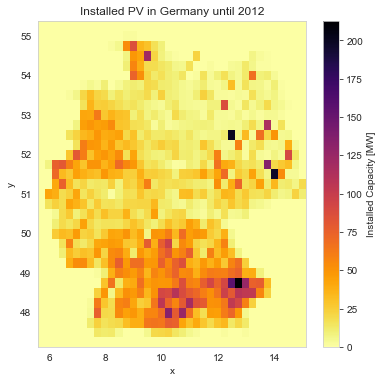

In [11]:
solar_layout = capacity_layout(cutout, 'Solarstrom', until="2012")

solar_layout.plot(cmap="inferno_r", size=6, aspect=1)
plt.title("Installed PV in Germany until 2012")

In [12]:
pv = cutout.pv(panel="CSi", orientation={'slope': 30., 'azimuth': 0.}, layout=solar_layout)

Convert and aggregate `pv`: 100% (12 of 12) || Elapsed Time: 0:00:05 Time:  0:00:05


In [13]:
pv_df = pd.DataFrame(dict(atlite=pv.sel(dim_0=0).to_pandas(),
                          opsd=opsd['DE_solar_generation_actual']))
pv_df = pv_df/1e3 # in GW

Text(0.5, 1.0, 'PV time-series Germany 2012')

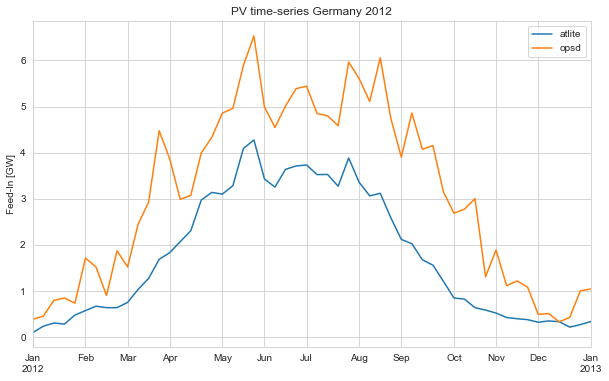

In [14]:
pv_df.resample('1W').mean().plot(figsize=(10,6))
plt.ylabel("Feed-In [GW]")
plt.title('PV time-series Germany 2012')

Text(0.5, 1.0, 'PV time-series Germany April 2012')

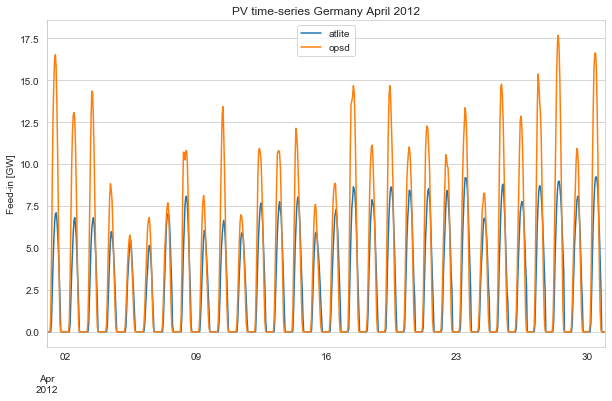

In [15]:
pv_df.loc["2012-04"].plot(figsize=(10,6))
plt.ylabel('Feed-in [GW]')
plt.title('PV time-series Germany April 2012')

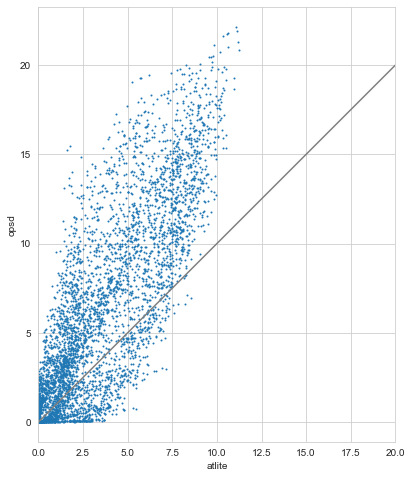

In [16]:
ax = pv_df.plot(x='atlite', y='opsd', kind='scatter', s=1, figsize=(12,8))
ax.set_aspect('equal')
ax.set_xlim(0,20)
ax.plot([0,20],[0,20], c='gray')

Text(0.5, 1.0, 'Duration curves')

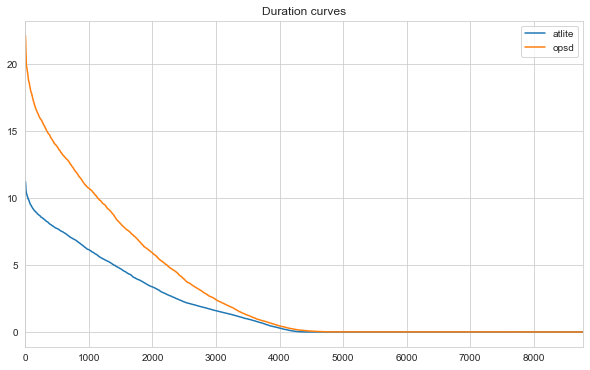

In [17]:
pv_df['atlite'].sort_values(ascending=False).reset_index(drop=True).plot(figsize=(10,6))
pv_df['opsd'].sort_values(ascending=False).reset_index(drop=True).plot(figsize=(10,6))
plt.legend()
plt.title('Duration curves')

## Wind

In [18]:
turbine_categories = [
        dict(name='Vestas_V25_200kW', up=400.),
        dict(name='Vestas_V47_660kW', up=700.),
        dict(name='Bonus_B1000_1000kW', up=1100.),
        dict(name='Suzlon_S82_1.5_MW', up=1600.),
        dict(name='Vestas_V66_1750kW', up=1900.),
        dict(name='Vestas_V80_2MW_gridstreamer', up=2200.),
        dict(name='Siemens_SWT_2300kW', up=2500.),
        dict(name='Vestas_V90_3MW', up=50000.)
    ]


In [19]:
low = 0
for index, turbine_cat in enumerate(turbine_categories):
    
    layout = capacity_layout(cutout, 'Windkraft',
                             cap_range=[low,turbine_cat['up']],
                             until="2012")
    
    turbine_categories[index]['layout'] = layout
    low = turbine_cat['up']

In [20]:
%%time
wind = xr.Dataset()
for turbine_cat in turbine_categories:
    name = f"< {turbine_cat['up']} kW"
    wind[name] = cutout.wind(turbine=turbine_cat['name'],
                   layout=turbine_cat['layout'])
    
wind['total'] = sum(wind[c] for c in wind)

Convert and aggregate `wind`: 100% (12 of 12) || Elapsed Time: 0:00:00 Time:  0:00:00
Convert and aggregate `wind`: 100% (12 of 12) || Elapsed Time: 0:00:00 Time:  0:00:00
Convert and aggregate `wind`: 100% (12 of 12) || Elapsed Time: 0:00:00 Time:  0:00:00
Convert and aggregate `wind`: 100% (12 of 12) || Elapsed Time: 0:00:00 Time:  0:00:00
Convert and aggregate `wind`: 100% (12 of 12) || Elapsed Time: 0:00:00 Time:  0:00:00
Convert and aggregate `wind`: 100% (12 of 12) || Elapsed Time: 0:00:00 Time:  0:00:00
Convert and aggregate `wind`: 100% (12 of 12) || Elapsed Time: 0:00:00 Time:  0:00:00
Convert and aggregate `wind`: 100% (12 of 12) || Elapsed Time: 0:00:00 Time:  0:00:00


Wall time: 5.36 s


In [21]:
wind_df = pd.DataFrame({"atlite":wind['total'].sel(dim_0=0).to_pandas(),
                            "< 1600 kW":wind['< 1600.0 kW'].sel(dim_0=0).to_pandas(),
                            "opsd":opsd['DE_wind_generation_actual']})

wind_df = wind_df/1e3 # in GW

Text(0.5, 1.0, 'Wind time-series Germany 2012')

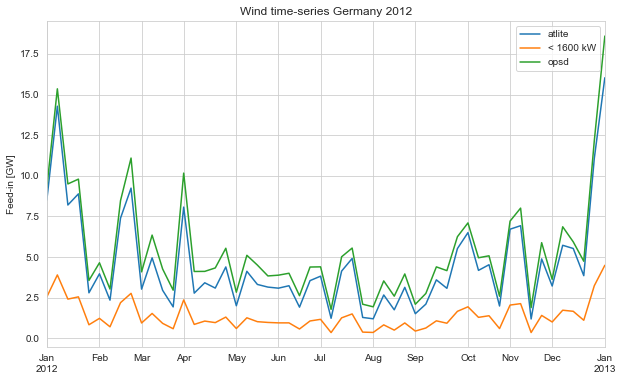

In [22]:
wind_df.resample('1W').mean().plot(figsize=(10,6))
plt.ylabel('Feed-in [GW]')
plt.title('Wind time-series Germany 2012')

Text(0.5, 1.0, 'Wind time-series Germany April 2012')

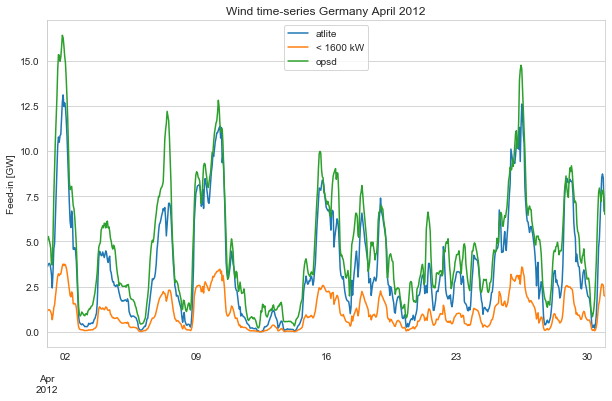

In [23]:
wind_df.loc["2012-04"].plot(figsize=(10,6))
plt.ylabel('Feed-in [GW]')
plt.title('Wind time-series Germany April 2012')

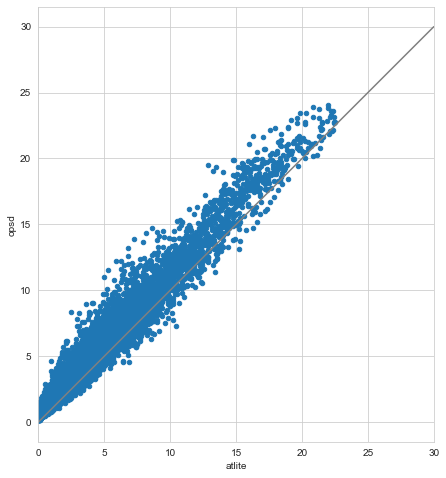

In [24]:
ax = wind_df.plot(x='atlite', y='opsd', kind='scatter', figsize=(12,8))
ax.set_aspect('equal')
ax.set_xlim(0,30)
ax.plot([0,30],[0,30],c='gray')

Text(0.5, 0, 'Accumulated hours')

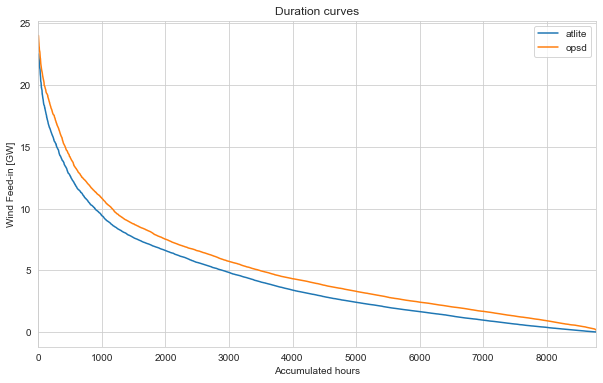

In [25]:
wind_df['atlite'].sort_values(ascending=False).reset_index(drop=True).plot(figsize=(10,6))
wind_df['opsd'].sort_values(ascending=False).reset_index(drop=True).plot(figsize=(10,6))
plt.legend()
plt.title('Duration curves')
plt.ylabel('Wind Feed-in [GW]')
plt.xlabel('Accumulated hours')

## Splitting time-series into shapes

The generation time-series can also be aggregated based on shapes.
In this example, we aggregate on the basis of the German "Laender" (federal states).

In [26]:
shp = shpreader.Reader(shpreader.natural_earth(resolution='10m',
                                               category='cultural',
                                               name='admin_1_states_provinces'))
de_records = list(filter(lambda r: r.attributes['iso_3166_2'].startswith('DE'), shp.records()))
laender = gpd.GeoDataFrame([{**r.attributes, 'geometry':r.geometry} for r in de_records]).rename(columns={"iso_3166_2":"state"}).set_index("state")

In [27]:
x1, y1, x2, y2 = de['geometry'].bounds

In [28]:
print(type(laender.loc['DE-TH'].geometry))
laender.loc['DE-TH']

<class 'shapely.geometry.polygon.Polygon'>


featurecla                                   Admin-1 scale rank
scalerank                                                     3
adm1_code                                              DEU-1577
diss_me                                                    1577
wikipedia                                                  None
                                    ...                        
name_tr                                              TÃ¼ringiya
name_vi                                              ThÃ¼ringen
name_zh                                               å¾ææ ¹
ne_id                                                1159310983
geometry      POLYGON ((9.949863314740185 51.30301870404992,...
Name: DE-TH, Length: 83, dtype: object

In [29]:
pv = cutout.pv(panel="CSi", orientation={'slope': 30., 'azimuth': 0.},
               shapes=laender['geometry'],
               layout=solar_layout)

Convert and aggregate `pv`: 100% (12 of 12) || Elapsed Time: 0:00:05 Time:  0:00:05


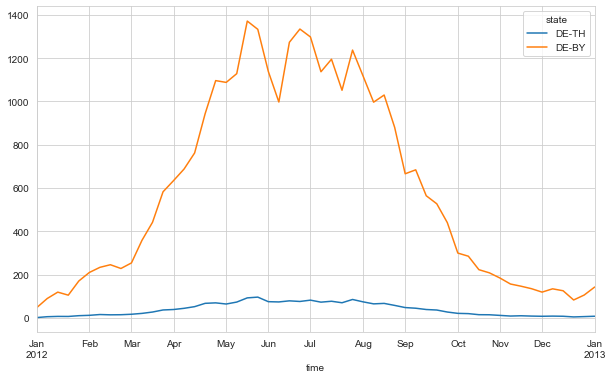

In [30]:
pv.sel(state=['DE-TH', 'DE-BY']).T.to_pandas().resample('1W').mean().plot(figsize=(10,6))